Welcome to Book Chatbot!
Ask me about any book, and I'll try to provide information.


Error fetching Google search links: HTTP Error 429: Too Many Requests
Book Chatbot:
Solo Leveling, also alternatively translated as Only I Level Up (Korean: 나 혼자만
레벨업; RR: Na Honjaman Rebeleop), is a South Korean web novel written by Chugong.
It was serialized in Kakao's digital comic and fiction platform KakaoPage
beginning on July 25, 2016, and was later published by D&C Media under their
Papyrus label since November 4, 2016. The novel has been licensed in English by
Yen Press. A webtoon adaptation of Solo Leveling was first serialized in
KakaoPage on March 4, 2018; it was illustrated by Jang Sung-rak (Dubu). The
webtoon's first season concluded on March 19, 2020, and its second season was
released from August 2020 to December 2021. Its individual chapters have been
collected and published by D&C Media in nine volumes as of August 2023. The
webtoon has been licensed in English by Yen Press. An anime television series
adaptation produced by A-1 Pictures aired from January to March 202

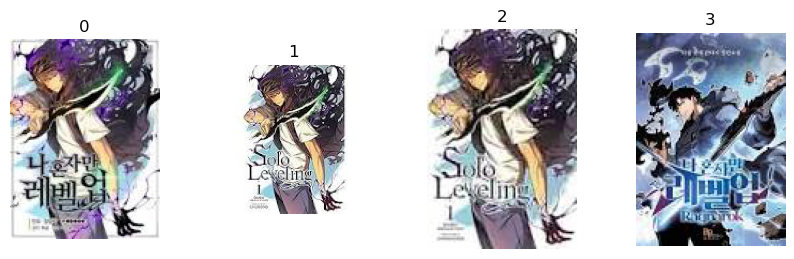

Sorry, couldn't find any relevant Google search links.


WikipediaException: An unknown error occured: "The "srsearch" parameter must be set.". Please report it on GitHub!

In [7]:



import wikipedia
from textblob import TextBlob
from spellchecker import SpellChecker
import re
import textwrap
import requests
import shutil
import numpy as np
from PIL import Image as PILImage
from PIL import ImageEnhance
from googlesearch import search
from termcolor import colored
from bs4 import BeautifulSoup
from IPython.display import display
import matplotlib.pyplot as plt

def preprocess_input(user_input):
    user_input = user_input.lower()  # Convert to lowercase
    spell = SpellChecker()
    tokens = TextBlob(user_input).words  # Tokenization
    corrected_tokens = []
    for token in tokens:
        # Skip spelling correction for non-English words
        if re.match(r'^[a-zA-Z]+$', token):
            corrected_tokens.append(spell.correction(token))
        else:
            corrected_tokens.append(token)
    return " ".join(corrected_tokens)

def search_book(book_title, user_query):
    try:
        page = wikipedia.page(book_title)
        content = page.content
        relevant_content = extract_relevant_content(content, user_query)
        
        # Extract multiple image URLs from Google Images
        image_urls = fetch_image_urls(book_title, 4)  # Fetch four images
        if not image_urls:
            return "Sorry, couldn't find any images for this book.", None, None
        
        # Fetch top 3 Google search links
        search_links = fetch_google_search_links(user_query, 3)
        
        # Download the images and save them locally
        image_paths = []
        for i, url in enumerate(image_urls):
            image_path = f"{book_title.replace(' ', '_')}_image_{i}.png"
            response = requests.get(url, stream=True)
            with open(image_path, 'wb') as out_file:
                shutil.copyfileobj(response.raw, out_file)
            image_paths.append(image_path)
        
        return relevant_content, image_paths, search_links
    except wikipedia.exceptions.DisambiguationError as e:
        return f"Multiple results found. Please be more specific: {', '.join(e.options)}", None, None
    except wikipedia.exceptions.PageError:
        return "Sorry, I couldn't find any information about that book.", None, None

def extract_relevant_content(content, user_query):
    relevant_content = ""
    sections = re.split(r'\n(?===)', content)  # Split content into sections
    for section in sections:
        if user_query.lower() in section.lower():
            relevant_content += section + '\n'
    return relevant_content

def fetch_image_urls(query, num_images):
    try:
        search_url = f"https://www.google.com/search?q={query.replace(' ', '+')}+book+cover&tbm=isch"
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(search_url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        img_tags = soup.find_all('img')
        # Extract URLs of the first 'num_images' images
        image_urls = [img['src'] for img in img_tags[1:num_images+1]]
        return image_urls
    except Exception as e:
        print("Error fetching image URLs:", e)
        return []

def fetch_google_search_links(query, num_links):
    try:
        search_links = list(search(query, num=num_links, stop=num_links, pause=2))
        return search_links
    except Exception as e:
        print("Error fetching Google search links:", e)
        return []

def display_output(content, image_paths, search_links):
    wrapper = textwrap.TextWrapper(width=80)
    wrapped_content = wrapper.fill(text=content)

    print(colored("Book Chatbot:", attrs=['bold']))
    print(wrapped_content)

    if image_paths:
        print(colored("\nImages:", 'green', attrs=['bold']))
        num_images = len(image_paths)
        
        # Create a figure and axes
        fig, axes = plt.subplots(1, num_images, figsize=(10, 3))

        # Iterate through image paths and display
        for ax, image_path in zip(axes, image_paths):
            image = PILImage.open(image_path)
            ax.imshow(image)
            ax.axis('off')  # Hide axes
            ax.set_aspect('equal')  # Equal aspect ratio
            ax.set_title(image_path.split('_')[-1].split('.')[0])  # Set title
        
        # Adjust spacing between subplots
        plt.subplots_adjust(wspace=0.4)

        plt.show()
            
    if search_links:
        print(colored("\nTop 3 Google Search Links:", 'blue', attrs=['bold']))
        for idx, link in enumerate(search_links, start=1):
            print(f"{idx}. {link}")
    else:
        print(colored("Sorry, couldn't find any relevant Google search links.", 'red', attrs=['bold']))

def main():
    print(colored("Welcome to Book Chatbot!", 'magenta', attrs=['bold']))
    print("Ask me about any book, and I'll try to provide information.")

    while True:
        user_input = input(colored("You: ", 'cyan', attrs=['bold']))
        if user_input.lower() == "exit":
            print(colored("Goodbye!", 'yellow', attrs=['bold']))
            break
        else:
            preprocessed_input = preprocess_input(user_input)
            response, images, search_links = search_book(preprocessed_input, user_input)
            display_output(response, images, search_links)

if __name__ == "__main__":
    main()
